TM10007 Classification ECG Data Group 7, 

Maartje Eijssen (4666925)

Lucie Wyatt (4683420)

Liza Kurucz (4535057)



Classification with Support Vector Machine and Logistic Regression

Output: score in Accuracy, F1 and ROC - curves

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


Cloning into 'tm10007_project'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 54 (delta 2), reused 8 (delta 2), pack-reused 45
Unpacking objects: 100% (54/54), done.


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

The score of SVM on test data: 0.855072463768116
The score of LR on test data: 0.8502415458937198
The F1-score of SVM on test data:
 0.8435175740575459
The F1 score of LR on test data:
 0.8418046358497336


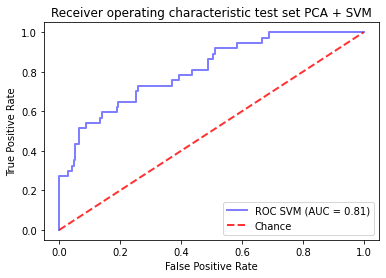

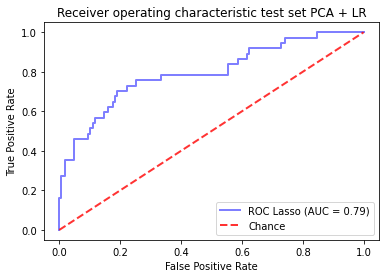

In [ ]:
# Import Required Packages
# General 
import numpy as np 
import matplotlib.pyplot as plt
from scipy.stats import randint
from scipy import stats
from pathlib import Path
import pandas as pd
import seaborn 
from time import time 
import math 
import os 
import zipfile

# Data preprocessing 
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import KFold

# Feature selection
from sklearn.feature_selection import SelectKBest
from sklearn import model_selection
from sklearn.decomposition import PCA 
from sklearn.feature_selection import SelectFromModel
from sklearn import decomposition 
from sklearn import neighbors

# Classification
from sklearn.svm import SVC
from sklearn import svm
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.model_selection import GridSearchCV

# Evaluation 
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

# Functions for plotting ROC curve
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from scipy import interp
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
import numpy as np
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import StratifiedKFold

# Import ECG Dataset
!git clone https://github.com/karinvangarderen/tm10007_project.git
with zipfile.ZipFile('/content/tm10007_project/ecg/ecg_data.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/tm10007_project/ecg')

# Dataframe containing 9000 features for 827 patients
data = pd.read_csv('/content/tm10007_project/ecg/ecg_data.csv', index_col=0)
features_df = data.iloc[:, :-1] # dataframe of all features per patient 
labels_df = data['label'] # dataframe of label per patient 

# Split data in train and testset, assign randomnly, stratify on the labels 
# 75% training data, 25% test data, (these sets change when you run again) 
train_f, test_f, train_l, test_l = model_selection.train_test_split(features_df, labels_df, test_size=0.25, stratify=labels_df)
training_data = pd.concat([train_f, train_l], axis=1) # training data, label included

# Scale all the features in your training data between 0 and 1
scaler = MinMaxScaler()
scaler.fit(training_data)
scaled_data = scaler.transform(training_data)
scaled_data = pd.DataFrame(scaled_data) #features+labels
scaled_features = scaled_data.iloc[:,:-1]

# Cross validation into five folds.  
cv = KFold(n_splits=5)
smoter = SMOTE(random_state=2)

# Create lists of data to train on and data to validate
Xs_train = [] #list of training features 
Ys_train = [] #list of training labels
Xs_val = []   #list of validation features 
Ys_val = []   #list of validation labels 

for index in cv.split(scaled_data):
    train = scaled_data.iloc[index[0]] #train
    val = scaled_data.iloc[index[1]]
    #Get training data 
    train_feature = train.iloc[:,:-1]
    train_label = train[train.columns[-1]].to_numpy()
    #Get validation data 
    val_feature = val.iloc[:,:-1]
    val_label =val[val.columns[-1]].to_numpy()
    #Upsample only the data in the training section
    get_train_feature_upsample, get_train_label_upsample = smoter.fit_resample(train_feature, train_label)
    Xs_train.append(get_train_feature_upsample)
    Ys_train.append(get_train_label_upsample)
    Xs_val.append(val_feature)
    Ys_val.append(val_label)

# Feature Selection PCA
selected_features_per_fold = []
val_selected_features_per_fold = []
for i, k in zip(Xs_train, Xs_val):
   pca = PCA(n_components=0.95)
   pca.fit(i)
   train_pca_f = pca.transform(i)
   val_pca_f = pca.transform(k)
   explained_variance = pca.explained_variance_ratio_
   selected_features_per_fold.append(train_pca_f)
   val_selected_features_per_fold.append(val_pca_f) 

# Feature Selection Lasso
c = 1
selected_features_lasso = []  #selected features after lasso selection on train data
val_selected_features_lasso = [] #selected features after lasso selection on validatie data
sel = SelectFromModel(LogisticRegression(C=c, penalty=('l1'), dual=False, solver='saga',class_weight='balanced')) #n_samples>n_features:False
for x_fold, y_fold, val_x_fold in zip(selected_features_per_fold, Ys_train, val_selected_features_per_fold):
    sel.fit(x_fold, np.ravel(y_fold, order='C'))
    sel.get_support() 
    x_fold = pd.DataFrame(x_fold)
    sel_features = x_fold.columns[(sel.get_support())]
    X_train_selected=sel.transform(x_fold)
    val_x_fold = pd.DataFrame(val_x_fold)
    val_X_train_selected=sel.transform(val_x_fold)
    selected_features_lasso.append(X_train_selected)
    val_selected_features_lasso.append(val_X_train_selected)

# Validation: 
#Scores for feature selection with PCA, Classification with SVM
for x_fold, y_fold, val_x_fold, val_y_fold  in zip(selected_features_per_fold, Ys_train, val_selected_features_per_fold, Ys_val):
    clf_SVM = SVC(kernel='poly', C=1.5, degree=1, gamma=0.05)
    clf_SVM.fit(x_fold,y_fold)
    train_scores2 = clf_SVM.score(x_fold,y_fold)
    valid_scores2= clf_SVM.score(val_x_fold,val_y_fold)

#Scores for features selection with PCA and L1 regularisation
#Classification with Logistic Regression 
for x_fold, y_fold, val_x_fold, val_y_fold  in zip(selected_features_lasso, Ys_train, val_selected_features_lasso, Ys_val):
    clf_L1 = LogisticRegression(C=1, penalty=('l1'), dual=False, solver='saga',class_weight='balanced')
    clf_L1.fit(x_fold,y_fold)
    train_scores = clf_L1.score(x_fold,y_fold)
    valid_scores= clf_L1.score(val_x_fold,val_y_fold)  

# Classifying test data 
test_data = pd.concat([test_f, test_l], axis=1) 
# Scale all the features in your test data between 0 and 1
scaled_data_test = scaler.transform(test_data)
scaled_data_test = pd.DataFrame(scaled_data_test) 
scaled_features_test = scaled_data_test.iloc[:,:-1]
labels_test = scaled_data_test.iloc[:,-1]
# feature selection with PCA
test_pca_f = pca.transform(scaled_features_test)
# Feature selection with LASSO
x_test_selected =sel.transform(test_pca_f)

# SVM classification
test_score_SVM = clf_SVM.score(test_pca_f, labels_test)
print(f'The score of SVM on test data: {test_score_SVM}')

# LASSO classification 
test_score_L1 = clf_L1.score(x_test_selected, labels_test)
print(f'The score of LR on test data: {test_score_L1}')

# Evaluation SVM
conf_mat_test_SVM = confusion_matrix(labels_test, clf_SVM.predict(test_pca_f)) # Confusion matrix
# F1 score
f1_test_SVM = f1_score(labels_test, clf_SVM.predict(test_pca_f), average='weighted')
print('The F1-score of SVM on test data:\n', f1_test_SVM)

# Evaluation Lasso 
conf_mat_test_L1 = confusion_matrix(labels_test, clf_L1.predict(x_test_selected)) # Confusion matrix
# F1 score
f1_test_L1 = f1_score(labels_test, clf_L1.predict(x_test_selected), average='weighted')
print('The F1 score of LR on test data:\n', f1_test_L1)

# AUC SVM 
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()

viz = plot_roc_curve(clf_SVM, test_pca_f, labels_test, name='ROC SVM', alpha=0.5, color='b', lw=2, ax=ax)
interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
interp_tpr[0] = 0.0
tprs.append(interp_tpr)
aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic test set PCA + SVM")
ax.legend(loc="lower right")
plt.show()


# AUC Lasso 
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()

viz = plot_roc_curve(clf_L1, x_test_selected, labels_test, name='ROC Lasso', alpha=0.5, color='b', lw=2, ax=ax)
interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
interp_tpr[0] = 0.0
tprs.append(interp_tpr)
aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic test set PCA + LR")
ax.legend(loc="lower right")
plt.show()


Additional plots used to assess the training procedure of both classifiers

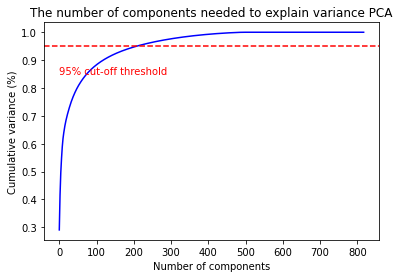

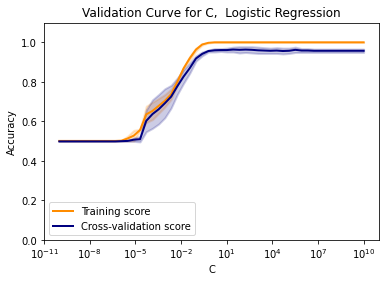

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


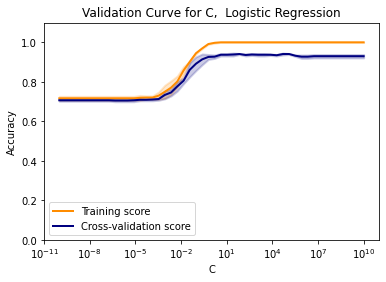

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


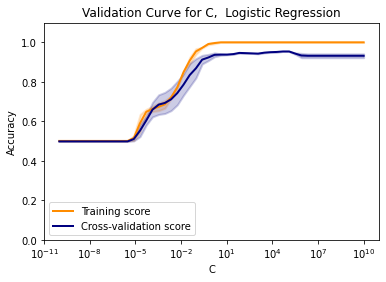

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


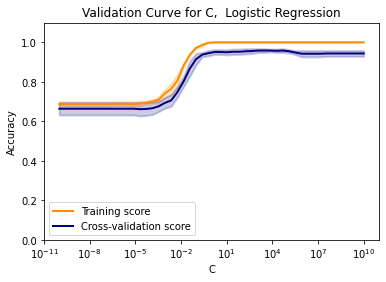

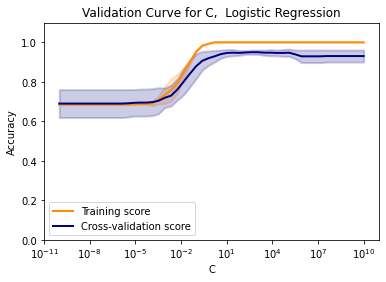

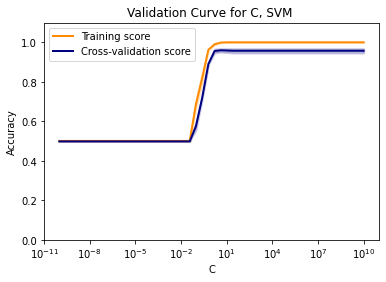

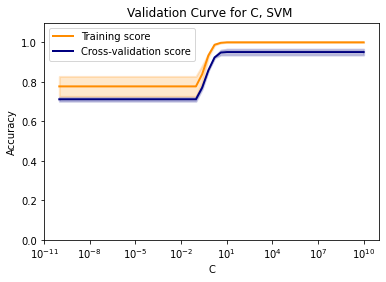

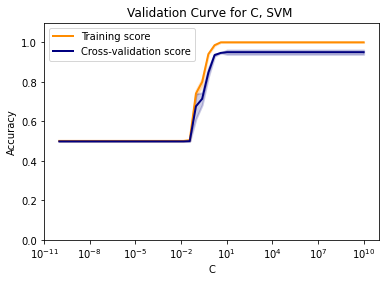

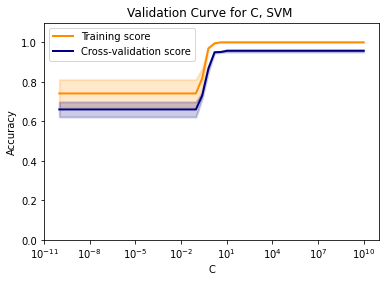

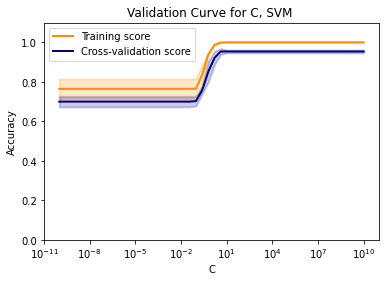

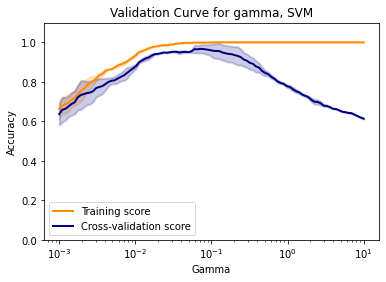

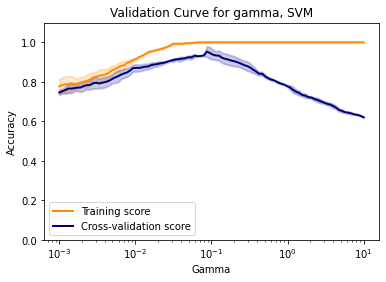

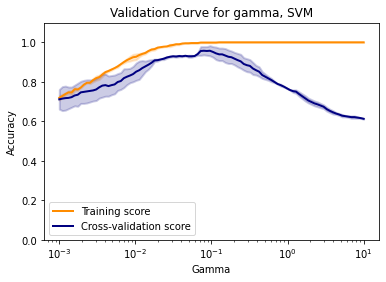

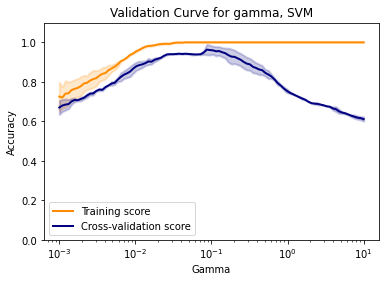

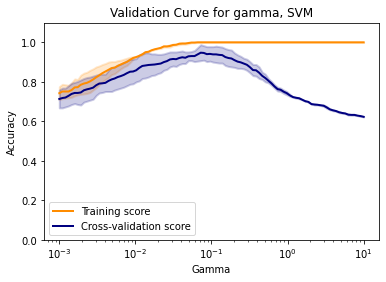

scores for fold:


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training scores for LR = 0.960880195599022
validation scores for LR = 0.8467741935483871
scores for fold:


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training scores for LR = 0.9421182266009852
validation scores for LR = 0.8145161290322581
scores for fold:


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training scores for LR = 0.9635036496350365
validation scores for LR = 0.8467741935483871
scores for fold:


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training scores for LR = 0.9754901960784313
validation scores for LR = 0.7903225806451613
scores for fold:


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Training scores for LR = 0.9560975609756097
validation scores for LR = 0.8064516129032258
scores for fold:
training scores for SVM = 0.9902200488997555
validation scores for SVM = 0.7903225806451613
scores for fold:
training scores for SVM = 0.9766009852216748
validation scores for SVM = 0.8870967741935484
scores for fold:
training scores for SVM = 0.9829683698296837
validation scores for SVM = 0.8629032258064516
scores for fold:
training scores for SVM = 0.9926470588235294
validation scores for SVM = 0.7903225806451613
scores for fold:
training scores for SVM = 0.9841463414634146
validation scores for SVM = 0.8145161290322581


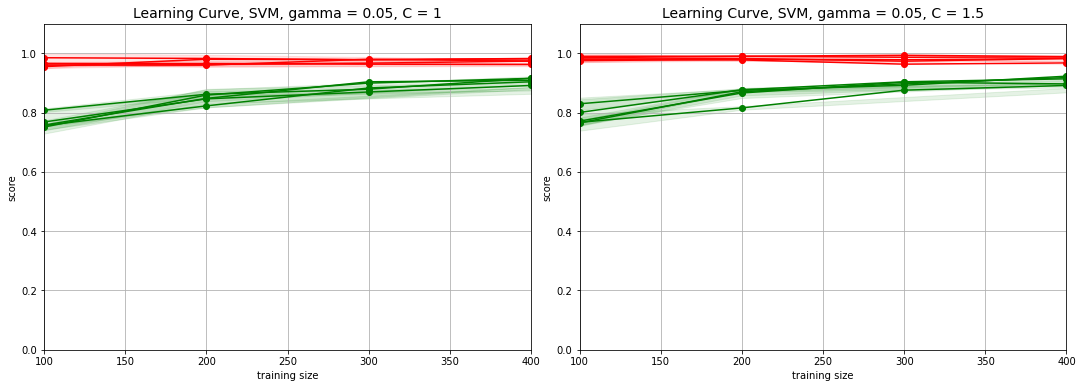

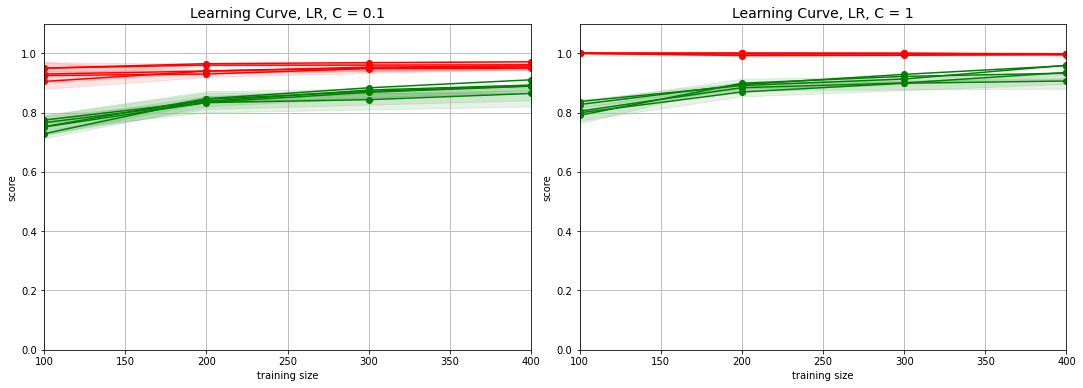

In [ ]:
# Plot explained variance PCA
fig, ax = plt.subplots()
pca = PCA().fit(Xs_train[0])
plt.plot(np.cumsum(pca.explained_variance_ratio_), color='b')
plt.xlabel('Number of components')
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance PCA')
plt.axhline(y=0.95, color='r', linestyle='--')
plt.text(0.5, 0.85, '95% cut-off threshold', color='red')
plt.show()


# Validation Curve of C for Logistic Regression model
param_range = np.logspace(-10,10)
for x_fold, y_fold in zip(selected_features_per_fold, Ys_train):
    train_scores, test_scores = validation_curve(
    LogisticRegression(), x_fold, y_fold, param_name="C", param_range=param_range,
    scoring="accuracy", n_jobs=1, cv = 2)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.title("Validation Curve for C,  Logistic Regression")
    plt.xlabel('C')
    plt.ylabel("Accuracy")
    plt.ylim(0.0, 1.1)
    lw = 2
    plt.semilogx(param_range, train_scores_mean, label="Training score",
                color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.2,
                    color="darkorange", lw=lw)
    plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
                color="navy", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.2,
                    color="navy", lw=lw)
    plt.legend(loc="best")
    plt.show()

# Validation Curve of slackfactor for SVM model
param_range = np.logspace(-10,10)
for x_fold, y_fold in zip(selected_features_per_fold, Ys_train):
    train_scores, test_scores = validation_curve(
    SVC(), x_fold, y_fold, param_name="C", param_range=param_range,
    scoring="accuracy", n_jobs=1, cv = 2)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.title("Validation Curve for C, SVM ")
    plt.xlabel('C')
    plt.ylabel("Accuracy")
    plt.ylim(0.0, 1.1)
    lw = 2
    plt.semilogx(param_range, train_scores_mean, label="Training score",
                color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.2,
                    color="darkorange", lw=lw)
    plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
                color="navy", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.2,
                    color="navy", lw=lw)
    plt.legend(loc="best")
    plt.show()

# Validation Curve of gamma for SVM model
param_range = np.logspace(-3,1,100)
for x_fold, y_fold in zip(selected_features_per_fold, Ys_train):
    train_scores, test_scores = validation_curve(
    SVC(), x_fold, y_fold, param_name="gamma", param_range=param_range,
    scoring="accuracy", n_jobs=1, cv = 2)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.title("Validation Curve for gamma, SVM")
    plt.xlabel('Gamma')
    plt.ylabel("Accuracy")
    plt.ylim(0.0, 1.1)
    lw = 2
    plt.semilogx(param_range, train_scores_mean, label="Training score",
                color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.2,
                    color="darkorange", lw=lw)
    plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
                color="navy", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.2,
                    color="navy", lw=lw)
    plt.legend(loc="best")
    plt.show()

# Scores for features election with PCA
# Classification with Logistic Regression 
for x_fold, y_fold, val_x_fold, val_y_fold  in zip(selected_features_lasso, Ys_train, val_selected_features_lasso, Ys_val):
    print('scores for fold:')
    clf_L1 = LogisticRegression(C=1, penalty=('l1'), dual=False, solver='saga',class_weight='balanced')
    clf_L1.fit(x_fold,y_fold)
    train_scores = clf_L1.score(x_fold,y_fold)
    valid_scores= clf_L1.score(val_x_fold,val_y_fold)  
    print('Training scores for LR =', train_scores)
    print('validation scores for LR =', valid_scores)

# Scores for feature selection with PCA
# Classification with SVM
for x_fold, y_fold, val_x_fold, val_y_fold  in zip(selected_features_per_fold, Ys_train, val_selected_features_per_fold, Ys_val):
    print('scores for fold:')
    clf_SVM = SVC(kernel='poly', C=1.5, degree=1, gamma=0.05)
    clf_SVM.fit(x_fold,y_fold)
    train_scores2 = clf_SVM.score(x_fold,y_fold)
    valid_scores2= clf_SVM.score(val_x_fold,val_y_fold)
    print('training scores for SVM =', train_scores2)  
    print('validation scores for SVM =', valid_scores2)

# Learning curve for SVM model for different C
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
cv = ShuffleSplit(n_splits=2, test_size=0.5)
train_sizes=[100,200,400,700]
for x_fold, y_fold  in zip(selected_features_per_fold, Ys_train):
    for i, c in enumerate([1, 1.5]):
        N, train_lc, val_lc = learning_curve(SVC(kernel='poly', gamma=0.05, degree=1, C=c),
                                            x_fold, y_fold, cv=cv,
                                            train_sizes=[100,200,300,400])

        ax[i].plot(N, np.mean(train_lc, 1), 'o-', color="r",
                 )
        ax[i].plot(N, np.mean(val_lc, 1),'o-', color="g",
                 )

        ax[i].set_ylim(0, 1.1)
        ax[i].grid()
        ax[i].fill_between(train_sizes, np.mean(train_lc, 1) - np.std(train_lc,1),
                         np.mean(train_lc, 1) + np.std(train_lc,1), alpha=0.1,
                         color="r")
        
        ax[i].fill_between(train_sizes, np.mean(val_lc, 1) - np.std(val_lc, 1),
                         np.mean(val_lc, 1) + np.std(val_lc, 1), alpha=0.1,
                         color="g")
        ax[i].set_xlim(N[0], N[-1])
        ax[i].set_xlabel('training size')
        ax[i].set_ylabel('score')
        ax[i].set_title('Learning Curve, SVM, gamma = 0.05, C = {0}'.format(c), size=14)

# Learning curve for Logistic Regression model
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
cv = ShuffleSplit(n_splits=2, test_size=0.5)
train_sizes=[100,200,400,700]
for x_fold, y_fold  in zip(selected_features_lasso, Ys_train):
    for i, c in enumerate([0.1, 1]):
        N, train_lc, val_lc = learning_curve(LogisticRegression(C=c),
                                            x_fold, y_fold, cv=cv,
                                            train_sizes=[100,200,300,400])

        ax[i].plot(N, np.mean(train_lc, 1), 'o-', color="r",
                 )
        ax[i].plot(N, np.mean(val_lc, 1),'o-', color="g",
               )

        ax[i].set_ylim(0, 1.1)
        ax[i].grid()
        ax[i].fill_between(train_sizes, np.mean(train_lc, 1) - np.std(train_lc,1),
                         np.mean(train_lc, 1) + np.std(train_lc,1), alpha=0.1,
                         color="r")
        
        ax[i].fill_between(train_sizes, np.mean(val_lc, 1) - np.std(val_lc, 1),
                         np.mean(val_lc, 1) + np.std(val_lc, 1), alpha=0.1,
                         color="g")
        ax[i].set_xlim(N[0], N[-1])
        ax[i].set_xlabel('training size')
        ax[i].set_ylabel('score')
        ax[i].set_title('Learning Curve, LR, C = {0}'.format(c), size=14)




